Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters from RandomizedSearchCV:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40, 'bootstrap': True}
Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       150
           1       0.87      0.98      0.92       145

    accuracy                           0.92       295
   macro avg       0.92      0.92      0.92       295
weighted avg       0.92      0.92      0.91       295

Confusion Matrix (Tuned Model):
[[128  22]
 [  3 142]]


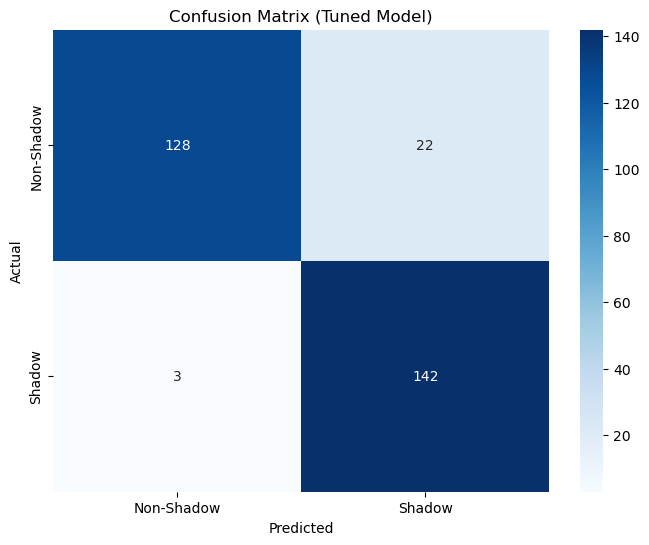

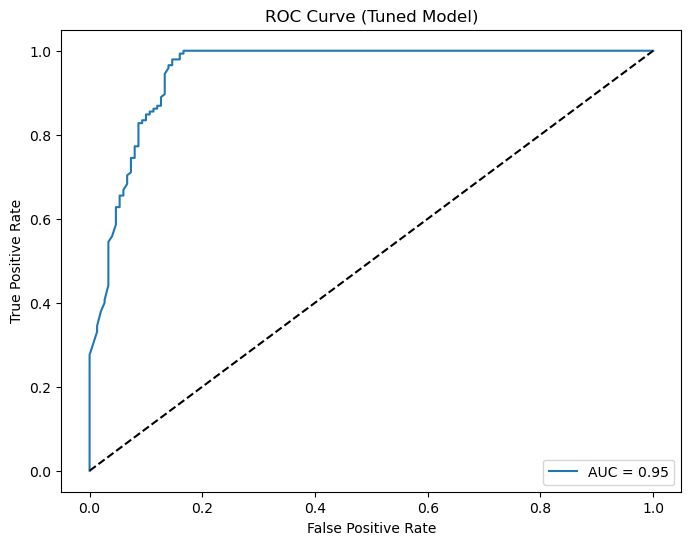

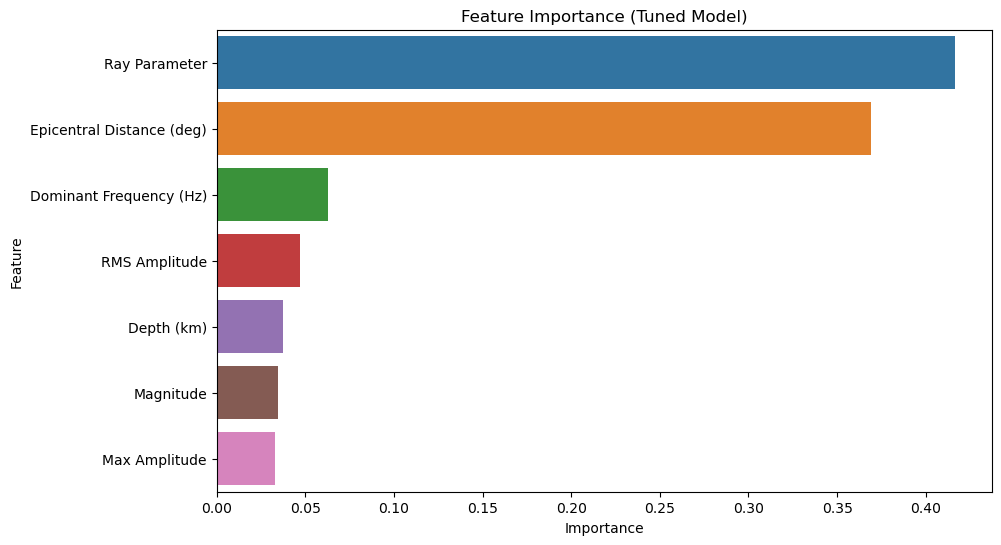

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# Function to preprocess data
def preprocess_data(df):
    # Select relevant features and target
    features = [
        "Depth (km)", 
        "Magnitude", 
        "Epicentral Distance (deg)", 
        "Ray Parameter", 
        "Max Amplitude", 
        "RMS Amplitude", 
        "Dominant Frequency (Hz)"
    ]
    X = df[features]
    y = df["Shadow Zone"]
    
    # Fill missing values with median
    X = X.fillna(X.median())
    
    # Normalize features (optional)
    X = (X - X.min()) / (X.max() - X.min())
    
    return X, y

# Functions for adding noise
def add_gaussian_noise(data, mean=0, std=0.01, random_state=42):
    np.random.seed(random_state)
    noise = np.random.normal(mean, std, data.shape)
    return data + noise

def add_uniform_noise(data, low=-0.05, high=0.05, random_state=42):
    np.random.seed(random_state)
    noise = np.random.uniform(low, high, data.shape)
    return data + noise

def add_salt_and_pepper_noise(data, amount=0.05, random_state=42):
    np.random.seed(random_state)
    noisy_data = data.copy()
    num_features = data.shape[1]
    for i in range(len(data)):
        indices = np.random.choice(num_features, size=int(amount * num_features), replace=False)
        noisy_data.iloc[i, indices] = np.random.choice([data.min().min(), data.max().max()], size=len(indices))
    return noisy_data

# Function for hyperparameter tuning with RandomizedSearchCV
def tune_random_forest(X_train, y_train, random_state=42):
    # Define the parameter grid
    param_grid = {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [None, 10, 20, 30, 40],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    }
    
    # Initialize the Random Forest Classifier
    rf = RandomForestClassifier(random_state=random_state)
    
    # RandomizedSearchCV for faster search
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=50,
        cv=3,
        verbose=2,
        random_state=random_state,
        n_jobs=-1
    )
    
    # Fit the random search to the data
    random_search.fit(X_train, y_train)
    
    print("Best Parameters from RandomizedSearchCV:")
    print(random_search.best_params_)
    
    return random_search.best_estimator_

# Provide the path to your CSV file
csv_file_path = r"Synthetic dataset.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Preprocess the data
X, y = preprocess_data(df)

# Add noise to the dataset
X_noisy = add_gaussian_noise(X, std=0.05, random_state=42)
X_noisy = add_uniform_noise(X_noisy, low=-0.1, high=0.1, random_state=42)
X_noisy = add_salt_and_pepper_noise(X_noisy, amount=0.05, random_state=42)

# Split noisy data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.2, random_state=42, stratify=y)

# Perform hyperparameter tuning
best_rf_model = tune_random_forest(X_train, y_train, random_state=42)

# Evaluate the tuned model
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

print("Classification Report (Tuned Model):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Tuned Model):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Shadow", "Shadow"], yticklabels=["Non-Shadow", "Shadow"])
plt.title("Confusion Matrix (Tuned Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve (Tuned Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Feature Importance of Tuned Model
feature_importances = best_rf_model.feature_importances_
features = [
    "Depth (km)", 
    "Magnitude", 
    "Epicentral Distance (deg)", 
    "Ray Parameter", 
    "Max Amplitude", 
    "RMS Amplitude", 
    "Dominant Frequency (Hz)"
]

importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    hue="Feature", 
    palette="tab10", 
    legend=False  
)
plt.title("Feature Importance (Tuned Model)")
plt.show()